# Setup

In [1]:
# for Python 3.9.6
%pip install -r requirements.txt

     |████████████████████████████████| 3.1 MB 3.4 MB/s eta 0:00:01
ERROR: Could not find a version that satisfies the requirement json (from -r requirements.txt (line 5)) (from versions: none)
ERROR: No matching distribution found for json (from -r requirements.txt (line 5))
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install SQLAlchemy
%pip install typing

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 78 kB 4.0 MB/s eta 0:00:011
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=86d0eccd145050f4f48f0c8ebd33d7c33a72311784c36aa62e76c5d84a8e548d
  Stored in directory: /home/bukold/.cache/pip/wheels/5e/5d/01/3083e091b57809dad979ea543def62d9d878950e3e74f0c930
Successfully built typing
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install mysql-connector-python-rf

     |████████████████████████████████| 11.9 MB 7.8 MB/s eta 0:00:01    |█▏                              | 419 kB 7.8 MB/s eta 0:00:02
  Created wheel for mysql-connector-python-rf: filename=mysql_connector_python_rf-2.2.2-cp38-cp38-linux_x86_64.whl size=249455 sha256=bc15c79ccf3c44144d751239c2096803c84f94999c3412ad9371f1e566f2c65a
  Stored in directory: /home/bukold/.cache/pip/wheels/f5/66/87/6d9cef740fd440ef390930fdbe6c761dc1efef78ec94a288fd
Successfully built mysql-connector-python-rf
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Setup
from src.hys_portal_scraper import Portal_Scraper
from src.scrapers.initiative_scraper import Initiative_Scraper
from src.scrapers.feedback_scraper import Feedback_Scraper
from src.scrapers.attachment_scraper import Attachment_Scraper

from src.database.seedlist_handler import SeedList_Handler

from src.database.database_connection import database_connection
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initalize Database
Database structure is defined in src/database/database_connection.py

In [6]:
# Only run once. Code creates new Database.
con = database_connection()
Portal_Scraper(con).init_database_session(create_db=True)

NameError: name 'database_connection' is not defined

# Upsert Seedlist to Database
Seedlist is a .txt document with one URL per line. The URL points to the initatives homepage, like <br> "https://ec.europa.eu/info/law/better-regulation/have-your-say/initiatives/1362-Access-to-Social-Protection_en"

In [13]:
# create Table named Seedlist and fill with initiative_id and more.
con = database_connection()
SeedList_Handler(connection=con).insert_seedlist("data/seedlist_manual_all_140424_additional-Inis.txt")

# Scrape Initiatives and Stage Metadata
Input are all Initative IDs that, according to seedlist are not scraped yet.

In [9]:
'''
1. Scrape all initatives where `initiative_updated` is Null in Seedlist Table
2. Upsert initative metadata in Initatives Table
3. Upsert stage metadata in Stages Table
4. Update 'initiative_updated' in Seedlist with current (GMT) time
'''

con = database_connection()

Initiative_Scraper(connection=con, wait_time=10).scrape_all() # wait_time = time between requests

logging     : INFO     Wait Time set to 10 sec.
logging     : INFO     Scraping 2 Initiatives...
logging     : INFO     ETA 00:00:20
logging     : WARNING  WARNING: No Data Found for 7567585
logging     : WARNING  WARNING: No Data Found for 7567586
logging     : INFO     scraped initiatives 2/2 [✔️ 🎉✨]
logging     : WARNING  2 initatives where not found.


[7567585, 7567586]

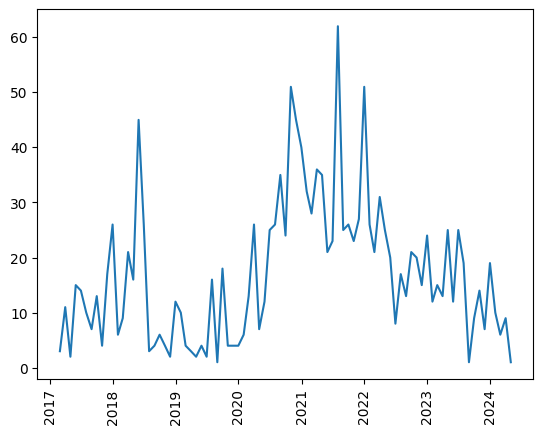

In [15]:
## display stages in DB by Published Date
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from src.database.database_connection import database_connection

engine = create_engine(database_connection(), echo=False, echo_pool=False)

stage_dates_published = pd.read_sql("SELECT published_date FROM stages", engine)

stage_dates_published = stage_dates_published.value_counts("published_date")
stage_dates_published = stage_dates_published.sort_index(ascending=True)

stage_dates_published = stage_dates_published.resample('M').agg("count")

plt.plot(stage_dates_published.index, stage_dates_published.values)
plt.xticks(rotation='vertical')
plt.show()

# Scrape Feedbacks and Attachment-Metadata

In [16]:
'''
1. Scrape all Stages where `feedback_updated` is Null in Stages Table
2. Upsert feedbacks to Feedbacks Table
3. Upsert attachment metadata to Attachments Table
4. Update 'feedback_updated' in Stages Table with current time
'''

con = database_connection()
Feedback_Scraper(connection=con, wait_time=10).scrape_all() # wait_time = time between requests

logging     : INFO     gmtime = 2024-05-27 09:03:51
logging     : INFO     Wait Time set to 10 sec.
logging     : INFO     Scraping Feedback of 420 Stages ...

logging     : INFO     Scraping Stage: 135125
logging     : INFO     ETA of Stage-Data 00:00:10
logging     : INFO     Scraped Page 1/1
logging     : INFO     Scraped 4 feedbacks

logging     : INFO     Scraping Stage: 221708
logging     : INFO     ETA of Stage-Data 00:00:30
logging     : INFO     Scraped Page 1/3
logging     : INFO     Scraped Page 2/3
logging     : INFO     Scraped Page 3/3
logging     : INFO     Scraped 27 feedbacks

logging     : INFO     Scraping Stage: 6242329
logging     : INFO     ETA of Stage-Data 00:02:40
logging     : INFO     Scraped Page 1/16
logging     : INFO     Scraped Page 2/16
logging     : INFO     Scraped Page 3/16
logging     : INFO     Scraped Page 4/16
logging     : INFO     Scraped Page 5/16
logging     : INFO     Scraped Page 6/16
logging     : ERROR    
logging     : INFO     Made 13 r

AttributeError: 'tuple' object has no attribute 'tb_frame'

# Scrape Attachments

In [ ]:
con = database_connection()
Attachment_Scraper(con, 5).scrape_all()